# Electron Photon tagging

This is a first test to implement a QAE and compare it to a classical AE.  
The task is to identify Electrons and Photons from em-calorimeter images.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
from tensorflow.keras import layers, losses
from matplotlib.colors import LogNorm
from hep_VQAE import utils as ut
import h5py
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [20]:
f = h5py.File("../../data/electron.hdf5","r")
f2 = h5py.File("../../data/photon.hdf5","r")

electrons = f.get('X')[:,:,:,0]
photons = f2.get('X')[:,:,:,0]
electrons_y = f.get('y')[:]
photons_y = f2.get('y')[:]

electrons = electrons / np.max(electrons)
photons = photons / np.max(electrons)

x_train, x_val, y_train, y_val = train_test_split(np.vstack((electrons,photons)),
                                                    np.transpose(np.hstack((electrons_y, photons_y))),
                                                    test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

x_train_electrons = x_train[y_train==1]
x_train = x_train[y_train==0]

x_val_electrons = x_val[y_val==1]
x_val = x_val[y_val==0]

x_test_electrons = x_test[y_test==1]
x_test = x_test[y_test==0]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 119835 but corresponding boolean dimension is 239040

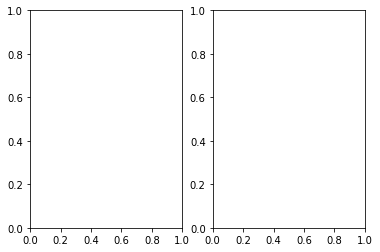

In [4]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(np.average(x_train[y_train==0],0))
axs[0].title.set_text('Photons')

axs[1].imshow(np.average(x_train[y_train==1],0))
axs[1].title.set_text('Electrons')

In [21]:
x_train = x_train.reshape(-1, x_train.shape[-1]*x_train.shape[-2])
x_test = x_test.reshape(-1, x_test.shape[-1]*x_test.shape[-2])

In [22]:
num_data, input_dim = x_train.shape

In [23]:
latent_dim = 16
ae = cae.Autoencoder1(input_dim, latent_dim)

In [24]:
ae.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.00001))

In [25]:
ae.build(x_train.shape)
ae.summary()

Model: "autoencoder1_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 16)                106198    
                                                                 
 sequential_3 (Sequential)   (119665, 1024)            107206    
                                                                 
Total params: 213,404
Trainable params: 213,404
Non-trainable params: 0
_________________________________________________________________


In [26]:
x_train_e = x_train[y_train==1]
x_train = x_train[y_train==0]

x_test_e = x_test[y_test==1]
x_test = x_test[y_test==0]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 119665 but corresponding boolean dimension is 239040

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
hist = ae.fit(x_train, x_train,
                epochs=5000,
                shuffle=True,
                batch_size=64,
                validation_data=(x_test, x_test),
                callbacks=[es])

Epoch 1/5000
1870/1870 [==============================] - 5s 3ms/step - loss: 0.6417 - val_loss: 0.5186
Epoch 2/5000
1870/1870 [==============================] - 5s 3ms/step - loss: 0.3042 - val_loss: 0.1280
Epoch 3/5000
1870/1870 [==============================] - 5s 3ms/step - loss: 0.0616 - val_loss: 0.0252
Epoch 4/5000
1870/1870 [==============================] - 5s 3ms/step - loss: 0.0144 - val_loss: 0.0081
Epoch 5/5000
1870/1870 [==============================] - 5s 3ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 6/5000
1870/1870 [==============================] - 5s 3ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 7/5000
1870/1870 [==============================] - 5s 3ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 8/5000
1870/1870 [==============================] - 5s 3ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/5000
1870/1870 [==============================] - 5s 3ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/5000
1870/1870 [==============================] - 5s 3m

In [ ]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

In [ ]:
def mae(x):
    pred = ae.predict(x)
    return np.mean(np.abs(x - pred)**2,axis=1)

def recon_acc(x):
    return 1 - mae(x)

def IF(x):
    pred = ae.predict(x)
    return 1 - np.sum((x - pred)**2,axis=(1,2))/np.sum(x*pred,axis=(1,2))
def IF2(x):
    pred = ae.predict(x)
    return 1 - np.sum((x - pred)**2,axis=(1,2))/np.sum(x**2,axis=(1,2))

In [17]:
photons = recon_acc(x_test)
electrons = recon_acc(x_test_e)

ValueError: in user code:

    File "/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "autoencoder1" (type Autoencoder1).
    
    in user code:
    
        File "/home/tom/Schreibtisch/Arbeit/Research-Projects/hep-VQAE/hep-VQAE/hep_VQAE/CAE.py", line 47, in call  *
            encoded = self.encoder(x)
        File "/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
            raise ValueError(f'Input {input_index} of layer "{layer_name}" is '
    
        ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 1024), found shape=(None, 32, 32)
    
    
    Call arguments received:
      • x=tf.Tensor(shape=(None, 32, 32), dtype=float32)


In [ ]:
print(np.median(photons))
bins = np.histogram(np.hstack((photons, electrons)), bins=10)[1]
plt.hist(photons, histtype='step', label="photons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
print(np.median(electrons))
plt.hist(electrons, histtype='step', label="electrons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.legend()

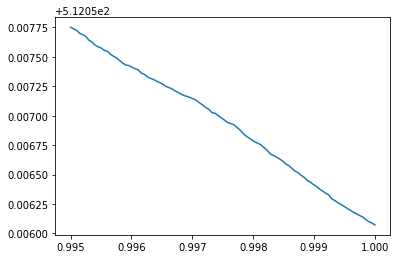

In [18]:
def acc_for_threshold(T):
    # sixes that are predicted photon
    num_six_right = np.sum(photons > T)
    # threes that are predicted three
    num_three_right = np.sum(electrons < T)
   
    acc = (num_six_right + num_three_right)/(len(photons) + len(electrons))
    return acc

Ts = np.linspace(0.995,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
plt.plot(Ts, accs) 

In [ ]:
recon = ae.predict(x_test).reshape((54,32,32))

ut.eval_recon(x_test.reshape((54,32,32)), recon, lognorm=True)

In [23]:
recon = ae.predict(x_test).reshape((54,32,32))
recon = ae.predict(x_test_electrons).reshape((54,32,32))

ut.eval_tagging(x_test[:1000], recon, x_test_electrons[:1000], recon_e)

(54, 1024)

In [18]:
x_test.shape

(54, 1024)

In [ ]:
num = 50
testimg = ae.predict(x_test[num].reshape((1,x_test[0].shape[0]))).reshape((32,32))
plt.imshow(x_test[num].reshape((32,32)),cmap="binary",norm=LogNorm())

In [ ]:
plt.imshow(testimg,cmap="binary",norm=LogNorm())

In [ ]:
ut.test_collapse(x_test[:100], ae.predict(x_test[:100]))